In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 57.9MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/titanic.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
titanic_data = pd.read_csv('/content/train.csv')

In [6]:
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<ipython-input-7-e66693fdec0c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(titanic_data.corr(), cmap="Spectral")


<function matplotlib.pyplot.show(close=None, block=None)>

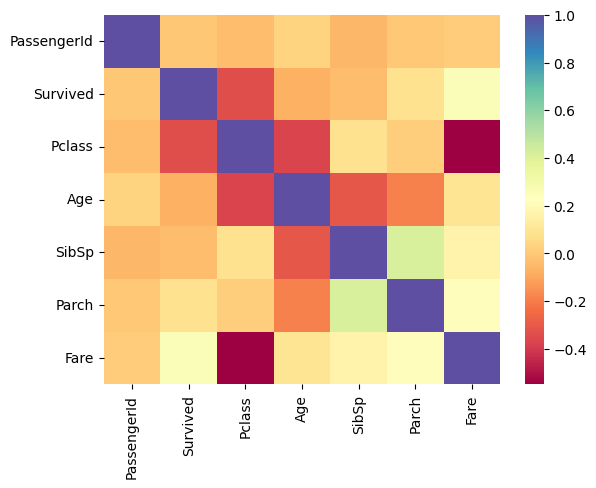

In [7]:
sns.heatmap(titanic_data.corr(), cmap="Spectral")
plt.show

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_indices, test_indices in split.split(titanic_data, titanic_data[["Survived","Pclass","Sex"]]):
  strat_train_set = titanic_data.loc[train_indices]
  strat_test_set = titanic_data.loc[test_indices]

<Axes: >

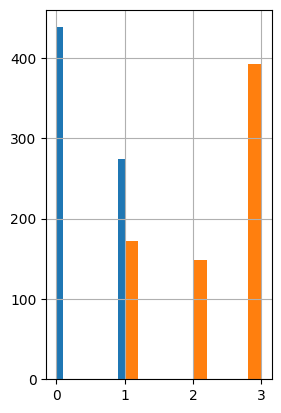

In [11]:
plt.subplot(1,2,1)
strat_train_set['Survived'].hist()
strat_train_set['Pclass'].hist()

<Axes: >

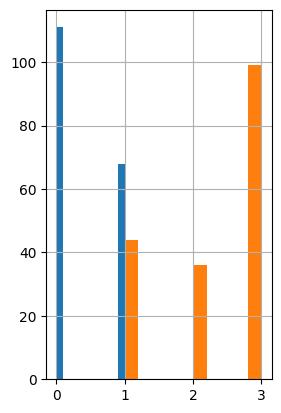

In [12]:
plt.subplot(1,2,2)
strat_test_set['Survived'].hist()
strat_test_set['Pclass'].hist()

In [13]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 608 to 351
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Name         712 non-null    object 
 4   Sex          712 non-null    object 
 5   Age          578 non-null    float64
 6   SibSp        712 non-null    int64  
 7   Parch        712 non-null    int64  
 8   Ticket       712 non-null    object 
 9   Fare         712 non-null    float64
 10  Cabin        164 non-null    object 
 11  Embarked     710 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 72.3+ KB


In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

In [16]:
class AgeImputer(BaseEstimator, TransformerMixin):
  def fit(self,X, y=None):
    return self

  def transform(self, X):
    imputer = SimpleImputer(strategy = "mean")
    X['Age'] = imputer.fit_transform(X[['Age']])
    return X

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self,X):
    encoder = OneHotEncoder()
    matrix = encoder.fit_transform(X[['Embarked']]).toarray()
    column_names = ["C", "S", "Q", "N"]
    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]

    matrix = encoder.fit_transform(X[['Sex']]).toarray()

    column_names = ["Female", "Male"]

    for i in range(len(matrix.T)):
      X[column_names[i]] = matrix.T[i]
    return X

In [19]:
class FeatureDropper(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X):
    return X.drop(["Embarked","Name","Ticket","Cabin","Sex","N"], axis=1, errors = 'ignore')

In [20]:
from sklearn.pipeline import Pipeline

In [21]:
pipeline = Pipeline([("ageimputer", AgeImputer()),("featureencoder", FeatureEncoder()),("featuredropper", FeatureDropper())])

In [22]:
strat_train_set = pipeline.fit_transform(strat_train_set)
strat_train_set

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
608,609,1,2,22.000000,1,2,41.5792,1.0,0.0,0.0,1.0,0.0
803,804,1,3,0.420000,0,1,8.5167,1.0,0.0,0.0,0.0,1.0
493,494,0,1,71.000000,0,0,49.5042,1.0,0.0,0.0,0.0,1.0
145,146,0,2,19.000000,1,1,36.7500,0.0,0.0,1.0,0.0,1.0
251,252,0,3,29.000000,1,1,10.4625,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
365,366,0,3,30.000000,0,0,7.2500,0.0,0.0,1.0,0.0,1.0
172,173,1,3,1.000000,1,1,11.1333,0.0,0.0,1.0,1.0,0.0
779,780,1,1,43.000000,0,1,211.3375,0.0,0.0,1.0,1.0,0.0
482,483,0,3,50.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0


In [23]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 608 to 351
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Survived     712 non-null    int64  
 2   Pclass       712 non-null    int64  
 3   Age          712 non-null    float64
 4   SibSp        712 non-null    int64  
 5   Parch        712 non-null    int64  
 6   Fare         712 non-null    float64
 7   C            712 non-null    float64
 8   S            712 non-null    float64
 9   Q            712 non-null    float64
 10  Female       712 non-null    float64
 11  Male         712 non-null    float64
dtypes: float64(7), int64(5)
memory usage: 72.3 KB


In [24]:
from sklearn.preprocessing import StandardScaler

X = strat_train_set.drop(['Survived'], axis = 1)
y = strat_train_set['Survived']

scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [27]:
clf = RandomForestClassifier()

In [28]:
param_grid = [{"n_estimators":[10,100,200,500], "max_depth": [None,5,10], "min_samples_split": [2,3,4]}]

In [29]:
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring = 'accuracy', return_train_score=True)
grid_search.fit(X_data, y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [30]:
final_clf = grid_search.best_estimator_

In [31]:
final_clf

RandomForestClassifier(max_depth=5, min_samples_split=4)

In [32]:
strat_test_set = pipeline.fit_transform(strat_test_set)

In [33]:
X_test = strat_test_set.drop(['Survived'], axis=1)
y_test = strat_test_set['Survived']

In [34]:
scaler = StandardScaler()
X_data_test = scaler.fit_transform(X_test)
y_data_test = y_test.to_numpy()

In [35]:
final_clf.score(X_data_test, y_data_test)

0.8044692737430168

In [36]:
final_data = pipeline.fit_transform(titanic_data)

In [37]:
final_data

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,C,S,Q,Female,Male
0,1,0,3,22.000000,1,0,7.2500,0.0,0.0,1.0,0.0,1.0
1,2,1,1,38.000000,1,0,71.2833,1.0,0.0,0.0,1.0,0.0
2,3,1,3,26.000000,0,0,7.9250,0.0,0.0,1.0,1.0,0.0
3,4,1,1,35.000000,1,0,53.1000,0.0,0.0,1.0,1.0,0.0
4,5,0,3,35.000000,0,0,8.0500,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.000000,0,0,13.0000,0.0,0.0,1.0,0.0,1.0
887,888,1,1,19.000000,0,0,30.0000,0.0,0.0,1.0,1.0,0.0
888,889,0,3,29.699118,1,2,23.4500,0.0,0.0,1.0,1.0,0.0
889,890,1,1,26.000000,0,0,30.0000,1.0,0.0,0.0,0.0,1.0


In [38]:
X_final = final_data.drop(['Survived'], axis=1)
y_final = final_data['Survived']

In [39]:
scaler = StandardScaler()
X_data_final = scaler.fit_transform(X_final)
y_data_final = y_final.to_numpy()

In [40]:
prod_clf = RandomForestClassifier()

In [41]:
param_grid = [{"n_estimators":[10,100,200,500], "max_depth": [None,5,10], "min_samples_split": [2,3,4]}]

In [42]:
grid_search = GridSearchCV(prod_clf, param_grid, cv=3, scoring = 'accuracy', return_train_score=True)
grid_search.fit(X_data_final, y_data_final)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [43]:
prod_final_clf = grid_search.best_estimator_

In [44]:
prod_final_clf

RandomForestClassifier(max_depth=5, min_samples_split=3)

In [45]:
titanic_test_data = pd.read_csv("/content/test.csv")

In [46]:
final_test_data = pipeline.fit_transform(titanic_test_data)

In [47]:
X_final_test = final_test_data
X_final_test = X_final_test.fillna(method="ffill")

In [48]:
scaler = StandardScaler()
X_data_final_test = scaler.fit_transform(X_final_test)

In [49]:
predictions = prod_final_clf.predict(X_data_final_test)

In [50]:
final_df = pd.DataFrame(titanic_test_data['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv("/content/predictions.csv", index = False)

In [51]:
final_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [52]:
predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,